In [1]:
import tensorflow as tf
import numpy as np
import os
import sys

slim = tf.contrib.slim

from nets import ssd_vgg_300, np_methods

In [2]:
# Input placeholder.
net_shape = (299, 299)
data_format = 'NHWC'
inputs = tf.placeholder(tf.float32, (None, 299, 299, 3), "input")
# Evaluation pre-processing: resize to SSD net shape.

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(inputs, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = 'checkpoints/ssd_300_vgg.ckpt/ssd_300_vgg.ckpt'

isess = tf.Session();

isess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph('checkpoints/ssd_300_vgg.ckpt/ssd_300_vgg.ckpt.index')
saver.restore(isess, ckpt_filename)

ssd_anchors = ssd_net.anchors(net_shape)
print("restored")

restored


In [3]:
with tf.variable_scope('select'):
    s_feed = tf.placeholder(tf.float32, [None, None, None, None, None], name="localizations")
    
    x_feed = tf.placeholder(tf.float32, [None, None, None], name="x")
    y_feed = tf.placeholder(tf.float32, [None, None, None], name="y")
    
    h_feed = tf.placeholder(tf.float32, [None], name="h")
    w_feed = tf.placeholder(tf.float32, [None], name="w")
    
    s_shape = tf.shape(s_feed)
    s_reshape = [-1, s_shape[-2], s_shape[-1]]
    s_feat_localizations = tf.reshape(s_feed, s_reshape)
    
    s_yref = tf.reshape(y_feed, [-1, 1])
    s_xref = tf.reshape(x_feed, [-1, 1])
    
    # Compute center, height and width
    s_cx = s_feat_localizations[:, :, 0] * w_feed * 0.1 + s_xref
    s_cy = s_feat_localizations[:, :, 1] * h_feed * 0.1 + s_yref
    s_w = w_feed * tf.exp(s_feat_localizations[:, :, 2] * 0.2)
    s_h = h_feed * tf.exp(s_feat_localizations[:, :, 3] * 0.2)

    s_ymin = s_cy - s_h / 2.
    s_xmin = s_cx - s_w / 2.
    s_xmax = s_cy + s_h / 2.
    s_ymax = s_cx + s_w / 2.

    s_stack = tf.stack([s_ymin, s_xmin, s_xmax, s_ymax], axis=1)

    s_transpose = tf.transpose(s_stack, [0,2,1])
    s_out_shape = [s_shape[0], -1, s_shape[-1]]
    s_bboxes = tf.reshape(s_transpose, s_out_shape, name="output")
    print(s_bboxes)

Tensor("select/output:0", shape=(?, ?, ?), dtype=float32)


In [4]:
with tf.variable_scope('choose'):
    p_feed = tf.placeholder(tf.float32, [None, None, None], name="predictions")
    pred_shape = tf.shape(p_feed)
    pred_layer = tf.reshape(p_feed, [pred_shape[0], -1, pred_shape[-1]])
    
    sub_pred = pred_layer[:, :, 1:]
    p_conditions = tf.greater(sub_pred, 0.5)
    ids = tf.where(condition=p_conditions)

In [16]:
def ssd_bboxes_select_layer(predictions_layer,
                            localizations_layer,
                            anchors_layer,
                            img_shape,
                            select_threshold=0.5):
    
    # Reshape features to: Batches x N x N_labels | 4.
    p_shape = predictions_layer.shape
    predictions_layer = np.reshape(predictions_layer,
                                   (p_shape[0], -1, p_shape[-1]))
    
    sub_predictions = predictions_layer[:, :, 1:]
    
    idxes = np.where(sub_predictions > select_threshold)
    
    id_out = isess.run([ids], feed_dict={p_feed: predictions_layer})
    
    box_feed = {s_feed: localizations_layer, y_feed: anchors_layer[0], x_feed: anchors_layer[1], \
                h_feed: anchors_layer[2], w_feed: anchors_layer[3]}
    
    localizations_output = isess.run([s_bboxes], feed_dict=box_feed)
    localizations_output = localizations_output[0]
    
    print("localizations_output", localizations_output.shape)
   
    classes = idxes[-1]+1
    scores = sub_predictions[idxes]
    bboxes = localizations_output[idxes[:-1]]

    return classes, scores, bboxes

def ssd_bboxes_select(predictions_net,
                      localizations_net,
                      anchors_net):
    """Extract classes, scores and bounding boxes from network output layers.

    Return:
      classes, scores, bboxes: Numpy arrays...
    """
    l_classes = []
    l_scores = []
    l_bboxes = []
    
    print("prediction length", len(predictions_net))
    for i in range(6):
        classes, scores, bboxes = ssd_bboxes_select_layer(
            predictions_net[i], localizations_net[i], anchors_net[i], img_shape=net_shape)
        
        l_classes.append(classes)
        l_scores.append(scores)
        l_bboxes.append(bboxes)

    classes = np.concatenate(l_classes, 0)
    scores = np.concatenate(l_scores, 0)
    bboxes = np.concatenate(l_bboxes, 0)
    return classes, scores, bboxes

In [17]:
# Main image processing routine.
bbox_img = tf.constant([[0., 0., 1., 1.]])

def process_image(img, nms_threshold=.45, net_shape=(299, 299)):
    # Run SSD network.
    rpredictions, rlocalisations, rbbox_img = isess.run([predictions, localisations, bbox_img],
                                                              feed_dict={'input:0': img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = ssd_bboxes_select(rpredictions, rlocalisations, ssd_anchors)
   
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)

    return rclasses, rscores, rbboxes

In [18]:
image_path = os.path.join('images/', 'street_smaller.jpg')

mean = tf.constant([123, 117, 104], dtype=tf.float32)

with tf.variable_scope('image'):
    image_data = tf.gfile.FastGFile(image_path, 'rb').read()
    #we want to use decode_image here but it's buggy
    decoded = tf.image.decode_jpeg(image_data, channels=None)
    normed = tf.divide(tf.cast(decoded, tf.float32), 255.0)
    batched = tf.expand_dims(normed, 0)
    resized_image = tf.image.resize_bilinear(batched, [299, 299])
    standard_size = resized_image
    graph_norm = standard_size * 255.0 - mean
    
with tf.Session() as sess:
    raw_image, file_image, plot_image = sess.run((decoded, graph_norm, standard_size), feed_dict={})


In [19]:
_, _, out_boxes = process_image(file_image)

('prediction length', 6)
('p_shape', (1, 38, 38, 4, 21))
ids
(array([0]), array([3279]))
[array([[   0, 3279,   14]])]
('localizations_output', (1, 5776, 4))
('p_shape', (1, 19, 19, 6, 21))
ids
(array([0, 0, 0, 0]), array([1179, 1181, 1293, 1295]))
[array([[   0, 1179,   14],
       [   0, 1181,   14],
       [   0, 1293,   14],
       [   0, 1295,   14]])]
('localizations_output', (1, 2166, 4))
('p_shape', (1, 10, 10, 6, 21))
ids
(array([0, 0, 0, 0, 0]), array([327, 329, 341, 387, 389]))
[array([[  0, 327,  14],
       [  0, 329,  14],
       [  0, 341,  14],
       [  0, 387,  14],
       [  0, 389,  14]])]
('localizations_output', (1, 600, 4))
('p_shape', (1, 5, 5, 6, 21))
ids
(array([0, 0]), array([63, 65]))
[array([[ 0, 63, 14],
       [ 0, 65, 14]])]
('localizations_output', (1, 150, 4))
('p_shape', (1, 3, 3, 4, 21))
ids
(array([], dtype=int64), array([], dtype=int64))
[array([], shape=(0, 3), dtype=int64)]
('localizations_output', (1, 36, 4))
('p_shape', (1, 1, 1, 4, 21))
ids
(a

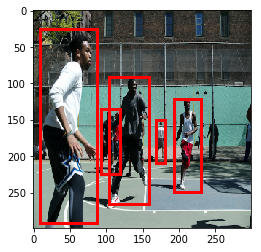

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

fig, ax = plt.subplots(1)
show_image = np.reshape(plot_image, (299,299,3))
ax.imshow(show_image)

for box in out_boxes:
    # Create a Rectangle patch
    x = box[1] * 299
    y = box[0] * 299
    w = (box[3]-box[1])*299
    h = (box[2]-box[0])*299
    
    rect = patches.Rectangle((x,y),w,h,linewidth=3,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()